## Quantization of TinyYolov2

In [25]:
import torch

# TODO: need to rerun everything on the machine wher it will be deployed?
# https://discuss.pytorch.org/t/runtimeerror-quantized-engine-qnnpack-is-not-supported/136524/6
# torch.backends.quantized.engine = 'qnnpack'

from torch.ao.quantization import fuse_modules
from torch.ao.quantization.fuse_modules import fuse_modules_qat
from models.q_tinyyolov2 import QTinyYoloV2
from utils.dataloader import VOCDataLoaderPerson
from utils.ap import display_roc, ap
from utils.yolo import train, test, print_size_of_model
import os
import time
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

In [26]:
print('Size of pretrained model (MB):', os.path.getsize("models/configs/voc_pretrained.pt")/1e6)
print('Size of finetuned model (MB):', os.path.getsize("models/configs/voc_finetuned.pt")/1e6)

Size of pretrained model (MB): 63.487048
Size of finetuned model (MB): 63.097671


In [ ]:
def net_time(model_class, testloader):
    
    #----to-be-done-by-student-------------------
    t_start = time.time()
    x, y = next(iter(testloader))
    model_class(x)
    t_end = time.time()
    #----to-be-done-by-student-------------------
    t = t_end - t_start
    return t

In [ ]:
from tqdm import tqdm

from utils.loss import YoloLoss
from utils.ap import ap, precision_recall_levels
from utils.yolo import filter_boxes, nms

def test(net, loader_test, conf_threshold=0.1, iou_threshold=0.5, device="cpu"):
    test_precision = []
    test_recall = []
    net.eval()
    with torch.no_grad():
        for idx, (input, target) in tqdm(enumerate(loader_test), total=350):
            input.to(device)
            target.to(device)
            output = net(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, conf_threshold)
            output = nms(output, iou_threshold)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if idx == 350:
                break
            
    print(test_precision)
    print(test_recall)
    return test_precision, test_recall

### Post-training static quantization (PTQ static)

In [40]:
qnet = QTinyYoloV2(num_classes=1)

# load pretrained state
state_dict = torch.load("models/configs/voc_finetuned.pt")
qnet.load_state_dict(state_dict)
# fuse Conv and BatchNorm layers
qnet.eval()
modules_to_fuse = [[f"conv{i}", f"bn{i}"] for i in range(1,9)]
fuse_modules(qnet, modules_to_fuse=modules_to_fuse, inplace=True)

print("Size of model after fusion:")
print_size_of_model(qnet)


Size of model after fusion:
Size (MB): 63.050584


In [49]:
qnet = QTinyYoloV2(num_classes=1)

# load pretrained state
state_dict = torch.load("models/configs/voc_finetuned.pt")
qnet.load_state_dict(state_dict)
# fuse Conv and BatchNorm layers
qnet.eval()
modules_to_fuse = [[f"conv{i}", f"bn{i}"] for i in range(1,9)]
qnet = fuse_modules(qnet, modules_to_fuse=modules_to_fuse)

print("Size of model after fusion:")
print_size_of_model(qnet)

Size of model after fusion:
Size (MB): 63.050584


In [53]:
print(qnet)

QTinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): Identity()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): Identity()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): Identity()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): Identity()
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): Identity()
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn7): Identity()
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn8): Identity()
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
  (quant): QuantStub()
  (dequant): DeQuantStub()
)


Post Training Quantization Prepare: Inserting Observers

 Conv1: After observer insertion 

 Conv2d(
  3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
  (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
)


100%|██████████| 350/350 [01:44<00:00,  3.34it/s]


[[0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1], [0.16666666666666666, 0.16666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.18181818181818182, 0.18181818181818182, 0.16666666666666666, 0.0, 1, 1, 1, 1, 1, 1, 1], [0.045454545454545456, 0.045454545454545456, 0.14285714285714285, 0.3333333333333333, 0.3333333333333333, 0.0, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1], [0.5, 0.5, 0.6666666666666666, 0.5, 1.0, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1], [0.1875, 0.1875, 0.5, 0.6, 0.5, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1], [0.6, 0.6, 0

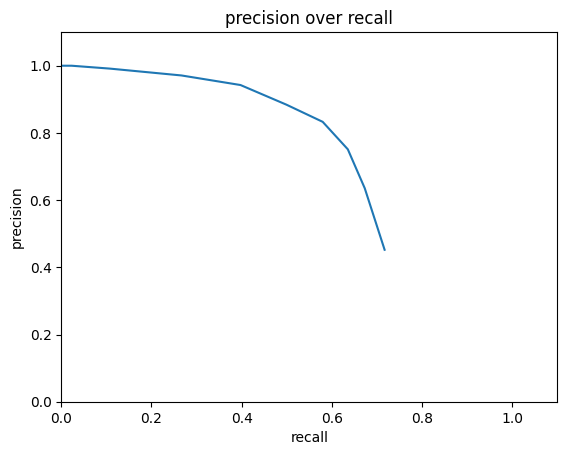

In [36]:
qnet.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(qnet, inplace=True)
print('Post Training Quantization Prepare: Inserting Observers')
print('\n Conv1: After observer insertion \n\n', qnet.conv1)

t_start = time.time()
test_precision, test_recall = test(qnet, loader_test)
print('Post Training Quantization: Calibration done')

torch.quantization.convert(qnet, inplace=True)
print('Post Training Quantization: Convert done')
print('\n Conv1: After fusion and quantization \n\n', qnet.conv1)

print("Size of model after quantization")
print_size_of_model(qnet)

avg_precision = ap(test_precision, test_recall)
print('average precision (AP): ', avg_precision)

display_roc(test_precision, test_recall)


In [ ]:
# Test inference speedup
print(f"Time quantized: {net_time(qnet, loader_test)} s")

In [37]:
qnet.to("cpu")
torch.save(qnet.state_dict(), f"results/voc_quantized_ptq.pt")

### Quantization-aware training (QAT)  
Modify the training loop by freezing the quantizer parameters (scale and zero-point) and fine tune the weights

In [56]:
qnet = QTinyYoloV2(num_classes=1)

# load pretrained state
state_dict = torch.load("models/configs/voc_finetuned.pt")
qnet.load_state_dict(state_dict)
# fuse Conv and BatchNorm layers
qnet.eval()
modules_to_fuse = [[f"conv{i}", f"bn{i}"] for i in range(1,9)]
qnet = fuse_modules_qat(qnet, modules_to_fuse=modules_to_fuse)

print("Size of model after fusion:")
print_size_of_model(qnet)

Size of model after fusion:
Size (MB): 63.095256


In [59]:
print(qnet)

QTinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.8522111177444458, zero_point=65, padding=(1, 1))
  (bn1): Identity()
  (conv2): QuantizedConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.679588258266449, zero_point=93, padding=(1, 1))
  (bn2): Identity()
  (conv3): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.3934989273548126, zero_point=78, padding=(1, 1))
  (bn3): Identity()
  (conv4): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.3181162476539612, zero_point=75, padding=(1, 1))
  (bn4): Identity()
  (conv5): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.25612637400627136, zero_point=73, padding=(1, 1))
  (bn5): Identity()
  (conv6): QuantizedConv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.24224622547626495, zero_point=79, padding=(1, 1))
  (bn6): Identity()
  (conv7): QuantizedConv2d(512, 1024, kernel_size=(3, 3), str

c:\Users\codau\Home\Uni\master_4\Embedded ML Lab\ml-lab-ss24-challenge\.venv\Lib\site-packages\torch\ao\quantization\observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



 Conv1: After fusion and quantization 

 ConvBn2d(
  3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
    (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
  )
  (activation_post_process): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
)
Epoch 1

100%|██████████| 2232/2232 [56:42<00:00,  1.52s/it] 


[[0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 1.0, 1.0, 1, 1, 1, 1], [0.2, 0.2, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.2857142857142857, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 

100%|██████████| 350/350 [00:36<00:00,  9.53it/s]


[[0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.42857142857142855, 0.42857142857142855, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1], [0.14285714285714285, 0.14285714285714285, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 1.0, 1, 1, 1, 1, 1], [0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.5, 0.5

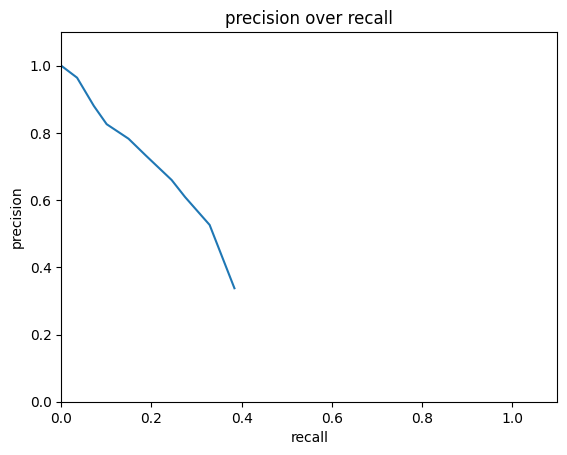

test average precision:  0.27383090160867946


In [58]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

qnet.train()
qnet.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(qnet, inplace=True)
print('\n Conv1: After fusion and quantization \n\n', qnet.conv1)
# qnet=qnet.cuda()

t_start = time.time()
qnet, test_AP = train(qnet, loader, loader_test, writer, freeze_q=True, num_epochs=1)
print('validation average precision: ', test_AP[-1])

#qnet_qat = qnet_qat.cpu()
torch.quantization.convert(qnet, inplace=True)
print("Size of model after quantization")
print_size_of_model(qnet)

test_precision, test_recall = test(qnet, loader_test)
display_roc(test_precision, test_recall)
print('test average precision: ', ap(test_precision, test_recall))


In [20]:
qnet.to("cpu")
torch.save(qnet.state_dict(), f"results/voc_quantized_qat.pt")

In [61]:
dummy_input = next(iter(loader))
torch.onnx.export(qnet, dummy_input, "results/voc_quantized.onnx", verbose=True)

c:\Users\codau\Home\Uni\master_4\Embedded ML Lab\ml-lab-ss24-challenge\models\q_tinyyolov2.py:118: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if yolo:


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [21]:
# Test inference speedup
print(f"Time quantized: {net_time(qnet, loader_test)} s")

RuntimeError: Error(s) in loading state_dict for QTinyYoloV2:
	Missing key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn5.weight", "bn5.bias", "bn5.running_mean", "bn5.running_var", "bn6.weight", "bn6.bias", "bn6.running_mean", "bn6.running_var", "bn7.weight", "bn7.bias", "bn7.running_mean", "bn7.running_var", "bn8.weight", "bn8.bias", "bn8.running_mean", "bn8.running_var". 
	Unexpected key(s) in state_dict: "conv1.bias", "conv1.scale", "conv1.zero_point", "conv2.bias", "conv2.scale", "conv2.zero_point", "conv3.bias", "conv3.scale", "conv3.zero_point", "conv4.bias", "conv4.scale", "conv4.zero_point", "conv5.bias", "conv5.scale", "conv5.zero_point", "conv6.bias", "conv6.scale", "conv6.zero_point", "conv7.bias", "conv7.scale", "conv7.zero_point", "conv8.bias", "conv8.scale", "conv8.zero_point", "conv9.scale", "conv9.zero_point", "quant.scale", "quant.zero_point". 
	While copying the parameter named "conv1.weight", whose dimensions in the model are torch.Size([16, 3, 3, 3]) and whose dimensions in the checkpoint are torch.Size([16, 3, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv2.weight", whose dimensions in the model are torch.Size([32, 16, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 16, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv3.weight", whose dimensions in the model are torch.Size([64, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 32, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv4.weight", whose dimensions in the model are torch.Size([128, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 64, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv5.weight", whose dimensions in the model are torch.Size([256, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([256, 128, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv6.weight", whose dimensions in the model are torch.Size([512, 256, 3, 3]) and whose dimensions in the checkpoint are torch.Size([512, 256, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv7.weight", whose dimensions in the model are torch.Size([1024, 512, 3, 3]) and whose dimensions in the checkpoint are torch.Size([1024, 512, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv8.weight", whose dimensions in the model are torch.Size([1024, 1024, 3, 3]) and whose dimensions in the checkpoint are torch.Size([1024, 1024, 3, 3]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).
	While copying the parameter named "conv9.weight", whose dimensions in the model are torch.Size([30, 1024, 1, 1]) and whose dimensions in the checkpoint are torch.Size([30, 1024, 1, 1]), an exception occurred : ('Copying from quantized Tensor to non-quantized Tensor is not allowed, please use dequantize to get a float Tensor from a quantized Tensor',).